## View and Vet an Exoplanet

Given a target name that was observed by Kepler. Pull down all the data. Flatten it. Fold it.
Examine a few things to see if other things could make it a false positive, like an eclipsing binary.

Define our inputs:
targetname={{TARGETNAME}}  #This is a Kepler Input Catalog Integer
period={{PERIOD}}  #This is a float
tzero. #this is float

In [78]:
#targetname={{TARGETNAME}}
#tzero={{TZERO}}
#period={{PERIOD}}
targetname=11446443
period=2.4706299  #Days
tzero=53957.13672 #MJD
tzero_bkjd=tzero+2400000.5-2454833.0 #We need times in bkjd to be consistent with Kepler.

In [115]:
#from lightkurve import KeplerTargetPixelFile
%matplotlib notebook
from lightkurve import KeplerLightCurveFile
from lightkurve import LightCurve
import numpy as np
import matplotlib.pyplot as plt

In [116]:
def getAllQuartersLc(targetname,period):
    times=[]
    sapfluxes=[]
    pdcfluxes=[]
    for i in np.arange(4)+1:
        lcf=KeplerLightCurveFile.from_archive(targetname, quarter=i)
        times.append(lcf.SAP_FLUX.time)
        sapfluxes.append(lcf.SAP_FLUX.flux)
        pdcfluxes.append(lcf.PDCSAP_FLUX.flux)
        
        
    saplc=LightCurve(time=np.concatenate(times).ravel(),flux=np.concatenate(sapfluxes).ravel())
    pdclc=LightCurve(time=np.concatenate(times),flux=np.concatenate(pdcfluxes))

    return saplc,pdclc

In [117]:
saplc,pdclc=getAllQuartersLc(targetname,period)

### Plot a flattened normalized lightcurve

In [123]:
#ADJUST THE NUMBER OF CADENCES IN THE FLATTENING HERE.
n_cadences=251
sapflat = saplc.flatten(window_length=n_cadences)
pdcflat = pdclc.flatten(window_length=n_cadences)

/Users/smullally/anaconda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/smullally/anaconda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<IPython.core.display.Javascript object>


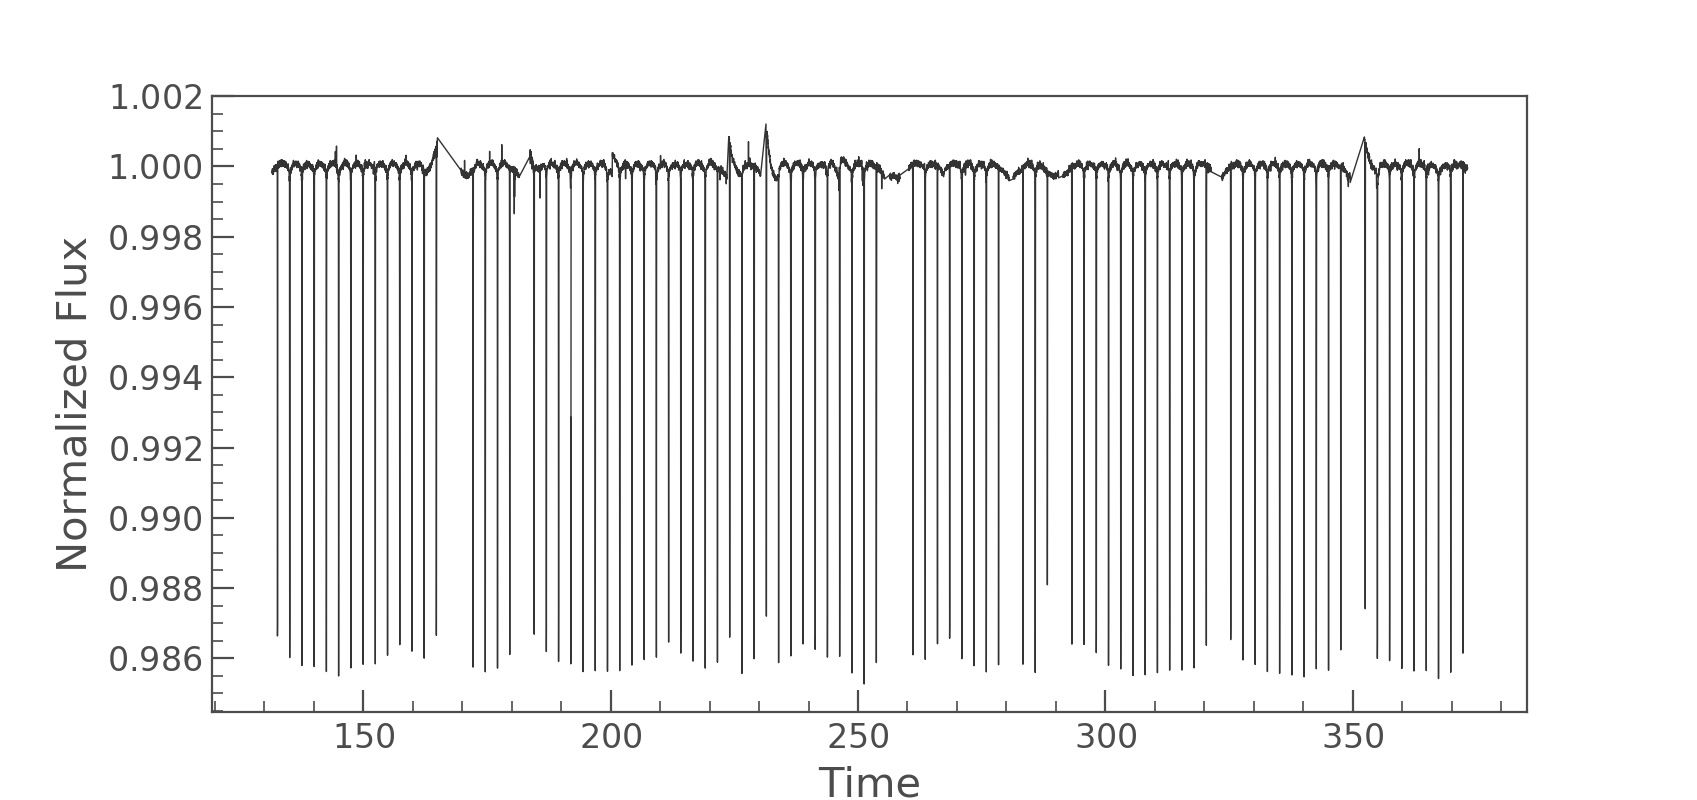

<IPython.core.display.Javascript object>


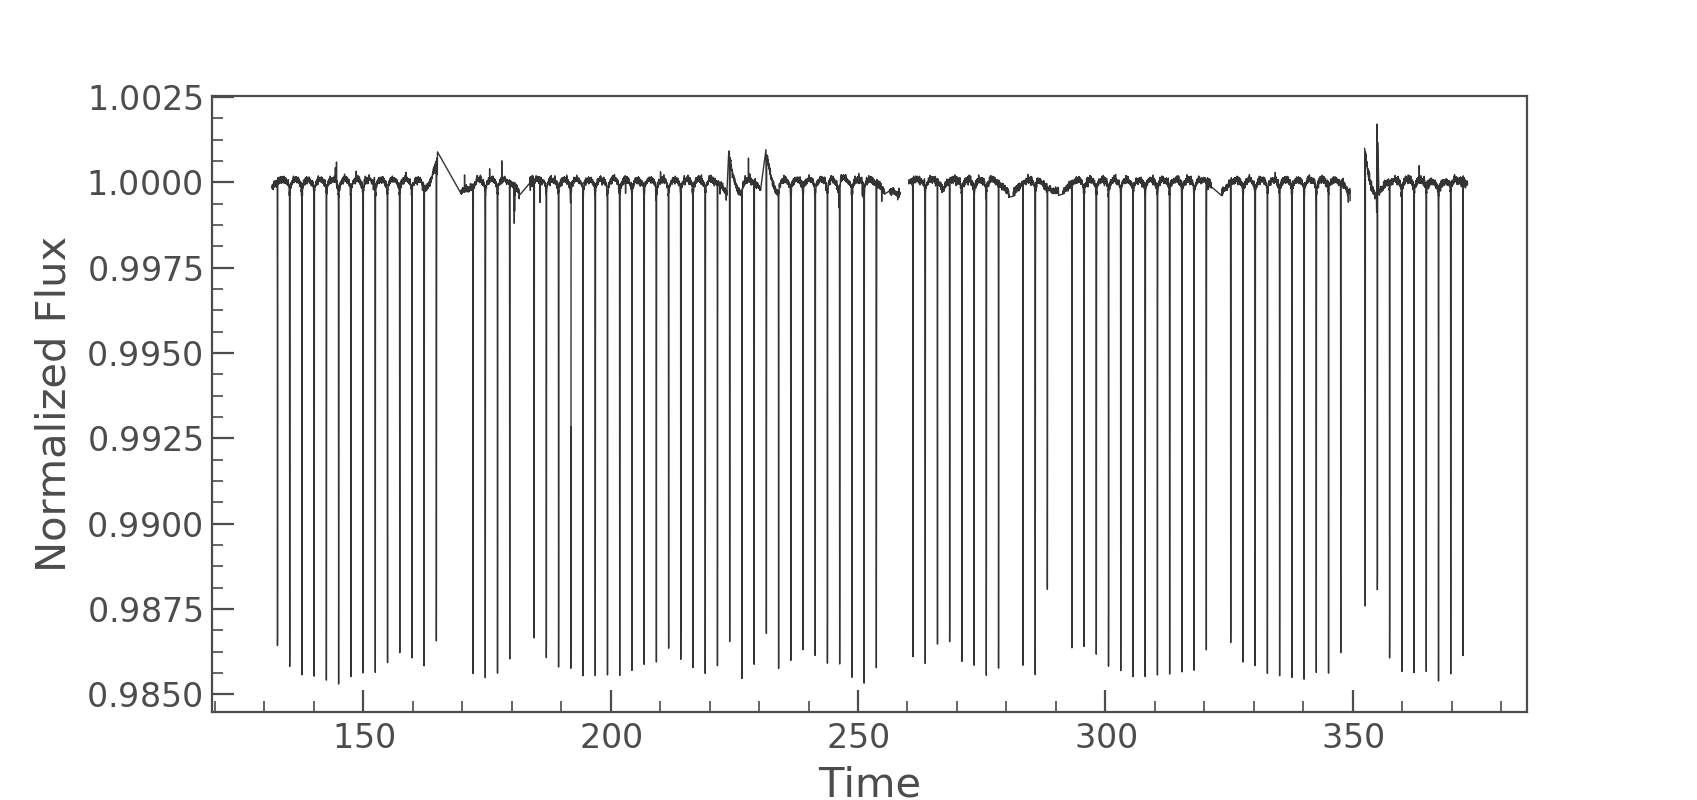

In [129]:
ax=sapflat.plot(title="SAP_FLUX Lightcurve")
pdcflat.plot(title="PDCSAP_FLUX Lightcurve")

### Plot Folded

<IPython.core.display.Javascript object>


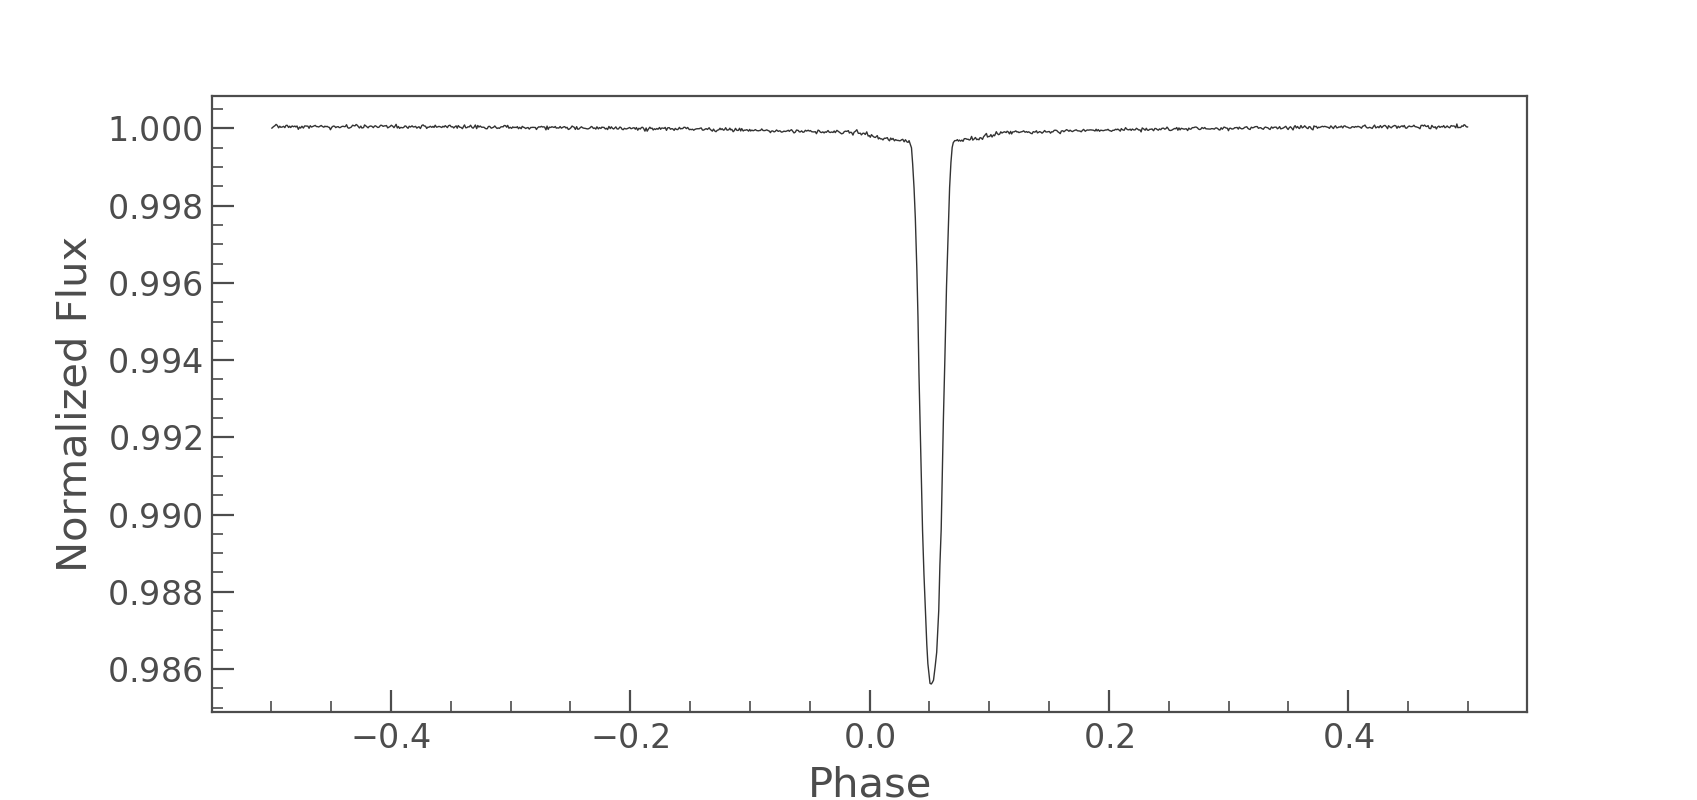

<IPython.core.display.Javascript object>


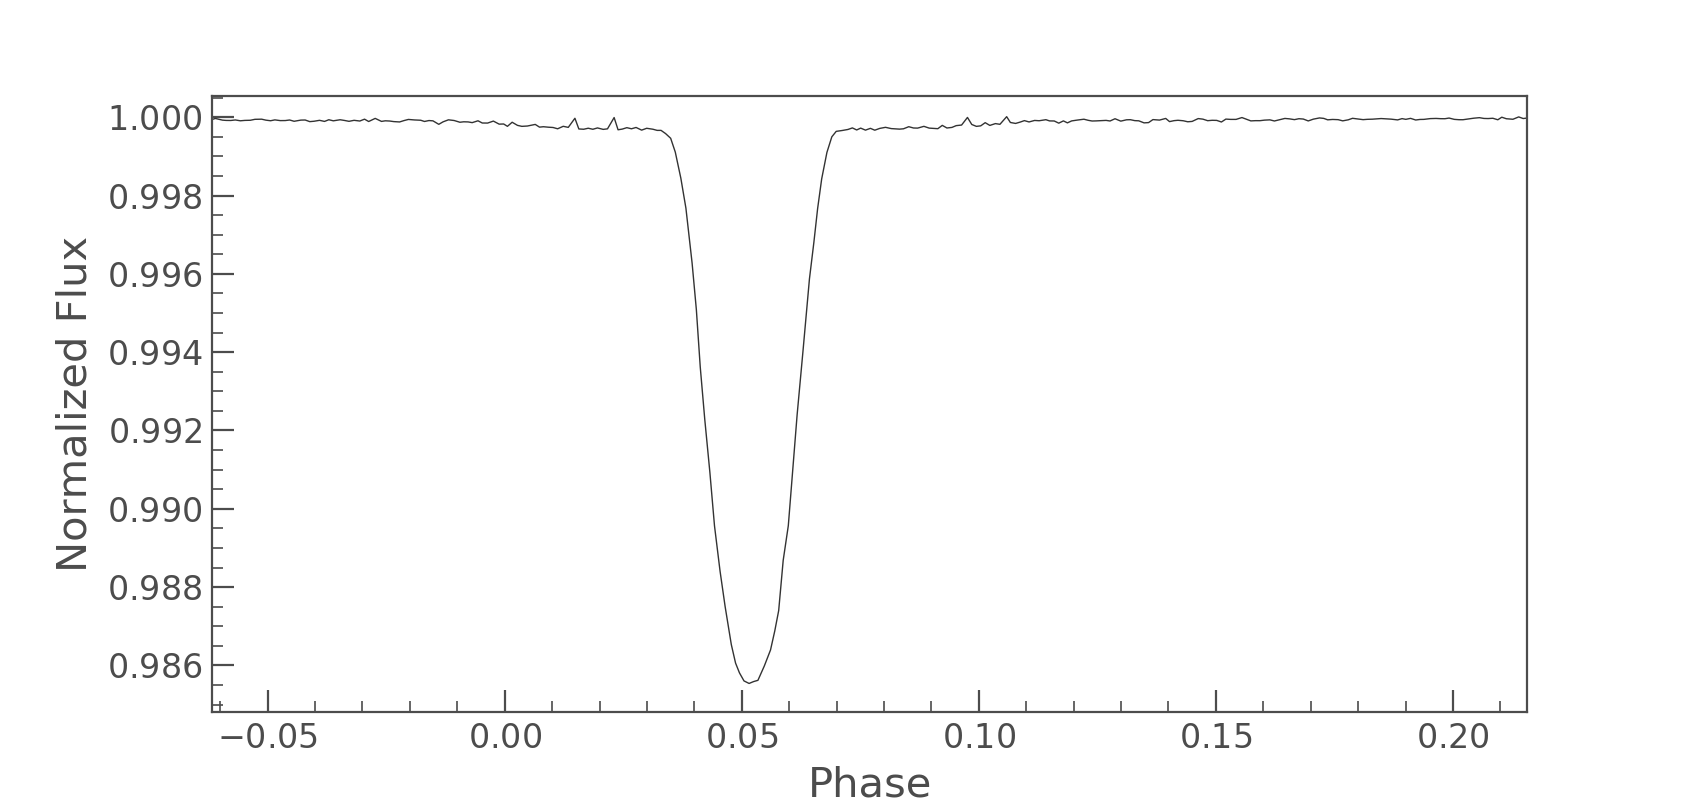

In [133]:
sapfold=sapflat.fold(period,phase=tzero_bkjd)
#Phases are in sapfold.phase
sapbin=sapfold.bin(binsize=11,method='median')
sapbin.plot()

pdcfold=pdcflat.fold(period,phase=tzero_bkjd)
#Phases are in sapfold.phase
pdcbin=pdcfold.bin(binsize=11,method='median')
pdcbin.plot(title="PDC Folded")

array([-0.49999544, -0.49970805, -0.49952926, ...,  0.4997602 ,
        0.49985974,  0.49988067])